In [84]:
import os 
import trimesh
import numpy as np 
import pickle
import pyvista as pv
from tqdm import tqdm
import imageio
from PIL import Image
#import cv2

In [85]:
def write_off(file, verts, faces):
    with open(file, 'w') as f:
        f.write("OFF\n")
        f.write(f"{verts.shape[0]} {faces.shape[0]} {0}\n")
        for x in verts:
            f.write(f"{' '.join(map(str, x))}\n")
        for x in faces:
            f.write(f"{len(x)} {' '.join(map(str, x))}\n")
            
def read_pickle(path):
    with open(path, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

def create_colormap(contour):
    minx = contour[:, 0].min()
    miny = contour[:, 1].min()
    minz = contour[:, 2].min()
    maxx = contour[:, 0].max()
    maxy = contour[:, 1].max()
    maxz = contour[:, 2].max()
    r = (contour[:, 0] - minx) / (maxx - minx)
    g = (contour[:, 1] - miny) / (maxy - miny)
    b = (contour[:, 2] - minz) / (maxz - minz)
    colors = np.stack((r, g, b), axis=-1)
    assert colors.shape == contour.shape
    return colors

def read_shape(filename):
    mesh = trimesh.load(filename, process=False, maintain_order=True)
    verts = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.faces)
    return mesh, verts, faces

def create_smaller_mesh(original_mesh, selected_vertex_indices):
    # Extract the selected vertices
    selected_vertices = original_mesh.points[selected_vertex_indices]

    # Create a mask to check if a vertex is selected
    vertex_mask = np.zeros(original_mesh.number_of_points, dtype=bool)
    vertex_mask[selected_vertex_indices] = True

    # Extract faces (connectivity array)
    faces = original_mesh.faces.reshape((-1, 4))[:, 1:]

    # Identify the faces that include the selected vertices
    mask = np.all(vertex_mask[faces], axis=1)
    selected_faces = faces[mask]

    # Adjust face indices to match the new vertex list
    new_index_map = {old_index: new_index for new_index, old_index in enumerate(selected_vertex_indices)}
    new_faces = np.vectorize(new_index_map.get)(selected_faces)

    # Flatten the faces array and prepend the face size (3 for triangles)
    new_faces = np.hstack([np.full((new_faces.shape[0], 1), 3), new_faces]).flatten()

    # Create the new mesh
    smaller_mesh = pv.PolyData(selected_vertices, new_faces)

    return smaller_mesh

def rotate_pv_mesh(mesh, rot):
    mesh = mesh.rotate_x(rot[0])
    mesh = mesh.rotate_y(rot[1])
    mesh = mesh.rotate_z(rot[2])
    return mesh


def trimesh2pv(trimesh_mesh):
    verts = np.asarray(trimesh_mesh.vertices)
    faces = np.asarray(trimesh_mesh.faces)

    mesh_pv = pv.PolyData(verts, np.hstack((np.full((faces.shape[0], 1), 3), faces))) 
        
    return mesh_pv

def create_rest_mesh(original_mesh, selected_vertex_indices):
    # Total number of points in the original mesh
    num_points = original_mesh.number_of_points
    
    # Create a mask to exclude selected vertices
    vertex_mask = np.ones(num_points, dtype=bool)
    vertex_mask[selected_vertex_indices] = False
    
    # Extract the remaining vertices
    remaining_vertices = original_mesh.points[vertex_mask]
    
    # Extract faces (connectivity array)
    faces = original_mesh.faces.reshape((-1, 4))[:, 1:]
    
    # Identify the faces that do not include any of the selected vertices
    mask = np.all(vertex_mask[faces], axis=1)
    remaining_faces = faces[mask]
    
    # Create a mapping from old indices to new indices
    new_index_map = {old_index: new_index for new_index, old_index in enumerate(np.where(vertex_mask)[0])}
    
    # Adjust face indices to match the new vertex list
    new_faces = np.vectorize(new_index_map.get)(remaining_faces)
    
    # Flatten the faces array and prepend the face size (3 for triangles)
    new_faces = np.hstack([np.full((new_faces.shape[0], 1), 3), new_faces]).flatten()
    
    # Create the new mesh
    smaller_mesh = pv.PolyData(remaining_vertices, new_faces)
    
    return smaller_mesh

def save_as_png(image_array, filename):
    image_array = Image.fromarray(image_array)
    image_array.save(filename)

def get_mesh_shadow(mesh):
    origin = mesh.center    
    bounds = mesh.bounds
    shadow_translation = (bounds[-1] - bounds[-2] * 1.0) / 2
    origin[-1] -= (shadow_translation-(shadow_translation*0.0)) 
    projected = mesh.project_points_to_plane(origin=origin)
    return projected


def load_pair(path, setting):
    files = os.listdir(path)
    meshes = {}
    names = {}
    pkls = {}

    x_full_name = [file for file in files if file.startswith("0_") and file.endswith(".off")][0]
    meshes["x_full"], _, _ = read_shape(os.path.join(path, x_full_name))
    names["x_name"] = x_full_name[7:-4]
    

    y_full_name = [file for file in files if file.startswith("1_") and file.endswith(".off")][0]
    meshes["y_full"], _, _ = read_shape(os.path.join(path, y_full_name))
    names["y_name"] = y_full_name[7:-4]
    

    x_pkl_name = [file for file in files if file.startswith("0_") and file.endswith(".pkl")][0]
    y_pkl_name = [file for file in files if file.startswith("1_") and file.endswith(".pkl")][0]
    

    pkls["x_pkl"] = read_pickle(os.path.join(path, x_pkl_name))
    pkls["y_pkl"] = read_pickle(os.path.join(path, y_pkl_name))
    

    p2p = np.load(os.path.join(path, "corres_10.npy"))
    p2p_inv = np.load(os.path.join(path, "corres_01.npy"))


    if setting != "full_full":
        y_partial_name = [file for file in files if file.startswith("1_") and file.endswith(".off")][0]
        meshes["y_partial"], _, _ = read_shape(os.path.join(path, y_partial_name))


    if setting == "partial_partial":
        x_partial_name = [file for file in files if file.startswith("0_") and file.endswith(".off")][0]
        meshes["x_partial"], _, _ = read_shape(os.path.join(path, x_partial_name))

    return meshes, names, pkls, p2p, p2p_inv


def generate_gif(plotter, path, pair_id, return_html=False):
    elevation = 15
    azimuths = np.arange(0, 361, 10)

    # elevation = 15
    # azimuth = 0
    
    # plotter.camera_position = 'yz'
    # plotter.camera.position = np.array([3, 3, 3])
    # plotter.camera.azimuth = azimuth
    # plotter.camera.elevation = elevation

    images = []
    
    for i in range(len(azimuths)):
        plotter.subplot(0, 0)
        plotter.camera.azimuth = azimuths[i]
        plotter.camera.elevation = elevation

        plotter.subplot(0, 1)
        plotter.camera.azimuth = azimuths[i]
        plotter.camera.elevation = elevation
        
        plotter.render()
        img = plotter.screenshot(return_img=True).astype(np.uint8)
        images += [img]
        if i == 0:
            save_as_png(img, os.path.join(path, f"{pair_id}.png"))

    imageio.mimwrite(os.path.join(path, f"{pair_id}.mp4"), images)
                
    # imageio.mimsave(os.path.join(path, f"{pair_id}.mp4"), images, fps=10, loop=0)


        
    #     img = plotter.screenshot(return_img=True).astype(np.uint8)
    #     images += [img]
    #     if i == 0:
    #         save_as_png(img, os.path.join(path, f"{pair_id}.png"))
            
    # imageio.mimsave(os.path.join(path, f"{pair_id}.gif"), images, format='GIF', fps=10, loop=0)

    if return_html:
        plotter.export_html(os.path.join(experiment_path, f'{id}.html'))

def convert_meshes_to_pv(meshes, setting):
    meshes_pv = {}
    meshes_pv["x_full"] = trimesh2pv(meshes["x_full"])

    meshes_pv["y_full"] = trimesh2pv(meshes["y_full"])
    
    if setting != "full_full":
        meshes_pv["y_partial"] = trimesh2pv(meshes["y_partial"])
        
    if setting == "partial_partial":
        meshes_pv["x_partial"] = trimesh2pv(meshes["x_partial"])
        
    return meshes_pv 

## Partial plot

In [86]:
def add_all_meshes_to_pv(plotter, meshes, pkls, p2p, shape_id, unmatched_color = [1, 0, 0], distance_factor=3):
    ambient = 0
    specular = 0
    diffuse = 0.6
    lighting = True
    show_edges=False
    metallic = True
    silhouette=False
    smooth_shading=True


    

    color = create_colormap(meshes["x_partial"].points)
    color[pkls["y_pkl"]["found_faces_mask"] == 0] = unmatched_color
    
    prefix = "x" if shape_id == 0 else "y"

    # meshes[f"{prefix}_partial"]  = rotate_pv_mesh(meshes[f"{prefix}_partial"], [90, 0, 0])

    if shape_id == 1:
        color = color[p2p]
        color[p2p == -1] = unmatched_color

    # add partial shape as wreframe
    helper_mesh = create_rest_mesh(meshes[f"{prefix}_full"], pkls[f"{prefix}_pkl"]["partial2full"])
    plotter.add_mesh(helper_mesh, color="lightgrey", lighting=True, ambient=ambient, silhouette=False, style="wireframe", line_width=1,
                     specular=0.1, show_edges=show_edges, diffuse=diffuse, metallic=metallic, smooth_shading=False, 
                     opacity=1.0, backface_params= {"culling": "none"})

    # add partial mesh 
    plotter.add_mesh(meshes[f"{prefix}_partial"], scalars=color, rgb=True, lighting=lighting, ambient=ambient, 
                     silhouette=silhouette,line_width=2, specular=specular, show_edges=show_edges, diffuse=diffuse, 
                     metallic=metallic, smooth_shading=smooth_shading)

    # add shadow 
    shadow = get_mesh_shadow(meshes[f"{prefix}_full"])
    plotter.add_mesh(shadow, color='lightgrey', opacity=1.0)

    # add light
    light = pv.Light(color='white', light_type='headlight', intensity=0.5)
    plotter.add_light(light)


    center = meshes[f"{prefix}_full"].center
    bounds = meshes[f"{prefix}_full"].bounds
    x_length = bounds[1] - bounds[0]
    y_length = bounds[3] - bounds[2]
    z_length = bounds[5] - bounds[4]
    max_length = max(x_length, y_length, z_length)
    distance = distance_factor * max_length
    camera_position = center + np.array([0, -distance, 0])
    plotter.camera.position = camera_position


# full plot 

In [87]:
def plot_mesh(plotter, meshes, pkls, p2p, p2p_inv, settings, rotation = [0, 0, 0], unmatched_color = [0.9, 0.9, 0.9], shape_id=0, setting='full', distance_factor = 3, plain = False):
    
    color = create_colormap(meshes["x_full"].points)
    #color[pkls["x_pkl"]["found_faces_mask"] == 0] = unmatched_color
    
    
    prefix = "x" if shape_id == 0 else "y"
    
    meshes[f"{prefix}_{setting}"]  = rotate_pv_mesh(meshes[f"{prefix}_{setting}"], rotation)


    if shape_id == 1:
        color = color[p2p]
        color[p2p == -1] = unmatched_color
    
    if shape_id == 0:
        color[p2p_inv == -1] = unmatched_color
    
    if plain:
        color[:] = unmatched_color

    # add full mesh 
    plotter.add_mesh(meshes[f"{prefix}_{setting}"], scalars=color, rgb=True, color="grey", lighting=settings['lighting'], ambient=settings['ambient'], 
                     silhouette=settings['silhouette'],line_width=settings['line_width'], edge_color=settings['edge_color'], specular=settings['specular'], show_edges=settings['show_edges'], diffuse=settings['diffuse'], 
                     metallic=settings['metallic'], smooth_shading=settings['smooth_shading'])

    # add shadow 
    shadow = get_mesh_shadow(meshes[f"{prefix}_{setting}"])
    plotter.add_mesh(shadow, color='lightgrey', opacity=1.0)

    # add light
    light = pv.Light(color='white', light_type='headlight', intensity=0.5)
    plotter.add_light(light)


    center = meshes[f"{prefix}_{setting}"].center
    bounds = meshes[f"{prefix}_{setting}"].bounds
    x_length = bounds[1] - bounds[0]
    y_length = bounds[3] - bounds[2]
    z_length = bounds[5] - bounds[4]
    max_length = max(x_length, y_length, z_length)
    distance = distance_factor * max_length
    camera_position = center + np.array([0, -distance, 0])
    plotter.camera.position = camera_position


# Main

### Single Shapes:

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2000, 1000) to (2000, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
/home/laehner/miniconda3/envs/neuralfms/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


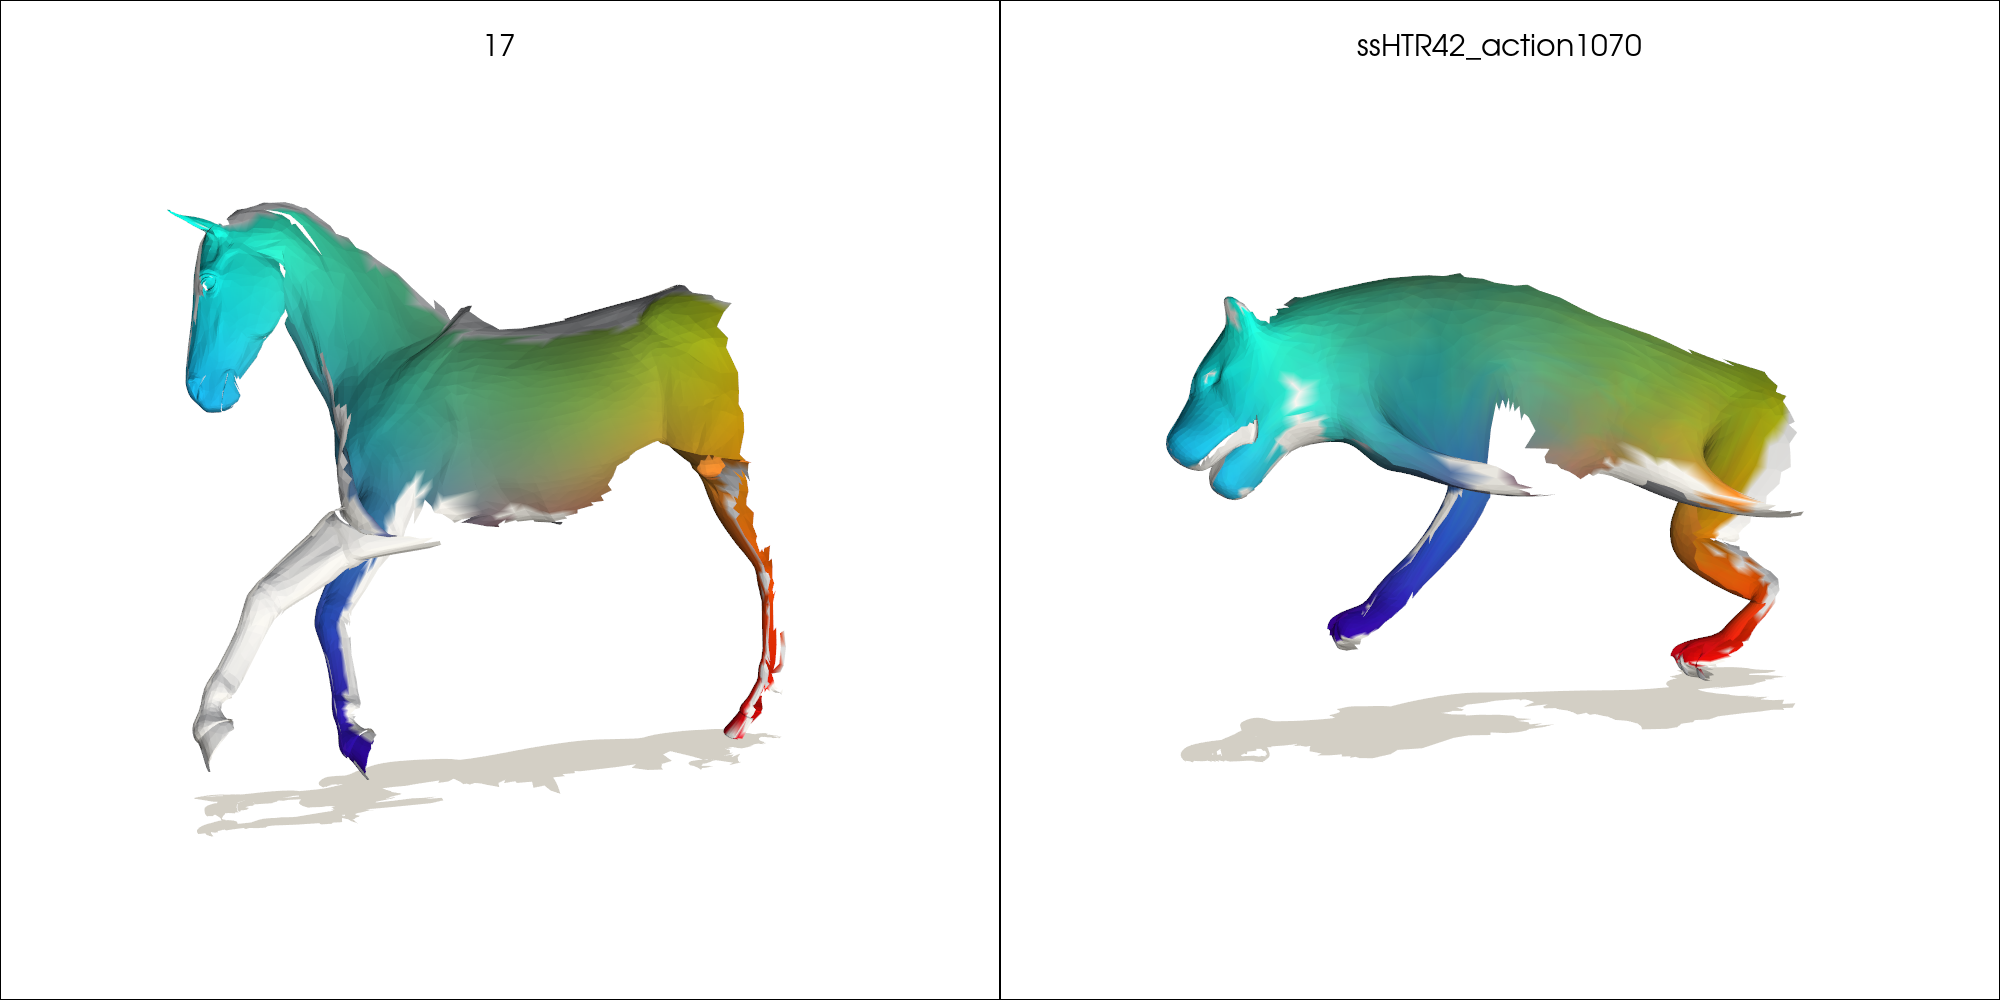

In [31]:
render_settings = {
    "ambient" : 0,
    "specular": 0,
    "diffuse" : 0.6,
    "lighting" : True,
    "show_edges" : False,
    "line_width" : 0.1,
    "edge_color" : [0.2, 0.2, 0.2],
    "metallic" : True,
    "silhouette" : False,
    "smooth_shading" : False,
    "partial_wire" : True
}

plain_color = False

for id in [75]:#range(1000): [20]
    #id = 0
    setting1 = "partial"
    setting2 = "partial"
    setting = setting1 + "_" + setting2
    folder = "/home/laehner/3D/BeCoS/" + setting + "/train/" + str(id) + "/"
    meshes, names, pkls, p2p, p2p_inv = load_pair(folder, setting)


    output_base_dir = "/home/laehner/sciebo - Lähner, Zorah (laehner@uni-bonn.de)@uni-bonn.sciebo.de/Forschung/Projects/Becos/"
    output_setting = os.path.join(output_base_dir, setting)
    os.makedirs(output_setting, exist_ok=True)



    plotter = pv.Plotter(shape=(1, 2), window_size=[2000, 1000])

    meshes = convert_meshes_to_pv(meshes, setting)
    
    rot = [90, 0, -50]
    meshes[f"x_{setting2}"] = rotate_pv_mesh(meshes[f"x_{setting2}"], rot)
    rot = [90, 0, -10]
    meshes[f"y_{setting1}"] = rotate_pv_mesh(meshes[f"y_{setting1}"], rot)

    
    # plots for shape x 
    plotter.subplot(0, 0)
    plot_mesh(plotter, meshes, pkls, p2p, p2p_inv, render_settings, shape_id=0, setting = setting2, plain = plain_color)
    plotter.add_title(f"{names['x_name']}", font_size=12)


    # plots for shape y
    plotter.subplot(0, 1)
    plot_mesh(plotter, meshes, pkls, p2p, p2p_inv, render_settings, shape_id=1, setting = setting1, plain = plain_color)

    plotter.add_title(f"{names['y_name']}", font_size=12)
    # plotter.link_views() 

    generate_gif(plotter, output_setting, id)
    #plotter.close()
    plotter.show()

In [15]:
print(meshes)

{'x_full': PolyData (0x77688ad30fa0)
  N Cells:    19797
  N Points:   9886
  N Strips:   0
  X Bounds:   -4.641e-01, 3.215e-01
  Y Bounds:   -8.760e-01, 8.751e-01
  Z Bounds:   -1.043e+00, 7.282e-01
  N Arrays:   1, 'y_full': PolyData (0x77688ad33dc0)
  N Cells:    19344
  N Points:   9680
  N Strips:   0
  X Bounds:   -3.790e-01, 2.383e-01
  Y Bounds:   -3.626e-01, 3.011e-01
  Z Bounds:   -9.924e-01, 7.134e-01
  N Arrays:   1}


### Examples Nafie: